## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test2
import friedman3Dataset
import network
import dataset
import sanityChecks
import torch 
import scrapbook as sb
from statistics import mean 
import catboost as ctb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np

## Parameters 

In [3]:
variance = 1
bias = 1 

In [4]:
# Parameters
variance = 0.1
bias = 1


## Dataset 


In [5]:
#Parameters 
n_features = 4
n_samples= 100
n_target = 1

In [6]:
X,Y = friedman3Dataset.friedman3_data(n_samples)

          X1           X2        X3        X4         Y
0  67.224187  1431.610790  0.708890  1.167570  1.529826
1  56.642474  1131.114898  0.205959  5.813949  1.453186
2  88.574198   898.637973  0.626683  9.059981  1.456708
3  89.361660  1518.339751  0.929497  9.707588  1.533585
4  43.025764  1737.182766  0.679312  5.988863  1.385420


In [7]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)


## Training Parameters 

In [8]:
batch_size = 32
n_epochs = 1000
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ABC Pre-generator Model 

1. The catboost model is used as a pre-generator model for the ABC-GAN. 
2. The model is first trained on the entire dataset 
3. It generats X,Y pairs and we add some Gaussian noise with mean 0 and variance 1 to it which is then feed as input to the generator.


In [9]:
#Train the Model 
prior_model = ctb.CatBoostRegressor()
prior_model.fit(X_train,Y_train)

Learning rate set to 0.027471
0:	learn: 0.9106917	total: 60.8ms	remaining: 1m
1:	learn: 0.9025705	total: 62ms	remaining: 31s
2:	learn: 0.8961442	total: 62.9ms	remaining: 20.9s
3:	learn: 0.8891390	total: 63.8ms	remaining: 15.9s
4:	learn: 0.8804741	total: 64.5ms	remaining: 12.8s
5:	learn: 0.8719106	total: 65ms	remaining: 10.8s
6:	learn: 0.8658596	total: 65.2ms	remaining: 9.25s
7:	learn: 0.8586600	total: 65.7ms	remaining: 8.14s
8:	learn: 0.8526912	total: 66.4ms	remaining: 7.31s
9:	learn: 0.8467129	total: 66.9ms	remaining: 6.62s
10:	learn: 0.8393753	total: 67.4ms	remaining: 6.06s
11:	learn: 0.8340450	total: 67.8ms	remaining: 5.58s
12:	learn: 0.8269826	total: 68.3ms	remaining: 5.18s
13:	learn: 0.8221363	total: 69.5ms	remaining: 4.9s
14:	learn: 0.8168823	total: 70.1ms	remaining: 4.61s
15:	learn: 0.8104064	total: 70.6ms	remaining: 4.34s
16:	learn: 0.8036758	total: 71.1ms	remaining: 4.11s
17:	learn: 0.7990086	total: 71.7ms	remaining: 3.91s
18:	learn: 0.7921353	total: 72.2ms	remaining: 3.73s
19

25:	learn: 0.7475929	total: 75.4ms	remaining: 2.82s
26:	learn: 0.7436715	total: 76.3ms	remaining: 2.75s
27:	learn: 0.7378779	total: 76.9ms	remaining: 2.67s
28:	learn: 0.7321466	total: 77.4ms	remaining: 2.59s
29:	learn: 0.7272524	total: 78ms	remaining: 2.52s
30:	learn: 0.7214795	total: 78.5ms	remaining: 2.46s
31:	learn: 0.7157874	total: 79ms	remaining: 2.39s
32:	learn: 0.7108238	total: 79.6ms	remaining: 2.33s
33:	learn: 0.7072588	total: 80ms	remaining: 2.27s
34:	learn: 0.7009745	total: 80.5ms	remaining: 2.22s
35:	learn: 0.6957856	total: 81ms	remaining: 2.17s
36:	learn: 0.6919099	total: 81.6ms	remaining: 2.12s
37:	learn: 0.6863587	total: 82ms	remaining: 2.08s
38:	learn: 0.6817813	total: 82.5ms	remaining: 2.03s
39:	learn: 0.6765912	total: 82.9ms	remaining: 1.99s
40:	learn: 0.6715415	total: 83.4ms	remaining: 1.95s
41:	learn: 0.6661175	total: 83.9ms	remaining: 1.91s
42:	learn: 0.6607524	total: 84.3ms	remaining: 1.88s
43:	learn: 0.6554909	total: 84.8ms	remaining: 1.84s
44:	learn: 0.6511181	t

223:	learn: 0.2601131	total: 158ms	remaining: 549ms
224:	learn: 0.2590581	total: 159ms	remaining: 549ms
225:	learn: 0.2575406	total: 160ms	remaining: 548ms
226:	learn: 0.2570267	total: 160ms	remaining: 546ms
227:	learn: 0.2560576	total: 161ms	remaining: 545ms
228:	learn: 0.2545997	total: 161ms	remaining: 543ms
229:	learn: 0.2535580	total: 162ms	remaining: 542ms
230:	learn: 0.2521728	total: 162ms	remaining: 540ms
231:	learn: 0.2513067	total: 163ms	remaining: 539ms
232:	learn: 0.2502769	total: 163ms	remaining: 537ms
233:	learn: 0.2488661	total: 164ms	remaining: 536ms
234:	learn: 0.2484412	total: 164ms	remaining: 534ms
235:	learn: 0.2477608	total: 165ms	remaining: 533ms
236:	learn: 0.2467931	total: 165ms	remaining: 531ms
237:	learn: 0.2458904	total: 165ms	remaining: 530ms
238:	learn: 0.2450357	total: 166ms	remaining: 528ms
239:	learn: 0.2442935	total: 166ms	remaining: 526ms
240:	learn: 0.2433205	total: 166ms	remaining: 524ms
241:	learn: 0.2429341	total: 167ms	remaining: 523ms
242:	learn: 

369:	learn: 0.1493032	total: 221ms	remaining: 376ms
370:	learn: 0.1488950	total: 222ms	remaining: 376ms
371:	learn: 0.1478505	total: 222ms	remaining: 375ms
372:	learn: 0.1470427	total: 223ms	remaining: 374ms
373:	learn: 0.1465868	total: 223ms	remaining: 373ms
374:	learn: 0.1461230	total: 223ms	remaining: 372ms
375:	learn: 0.1456817	total: 224ms	remaining: 372ms
376:	learn: 0.1446799	total: 224ms	remaining: 371ms
377:	learn: 0.1437554	total: 225ms	remaining: 370ms
378:	learn: 0.1429823	total: 225ms	remaining: 369ms
379:	learn: 0.1425628	total: 226ms	remaining: 368ms
380:	learn: 0.1418788	total: 226ms	remaining: 367ms
381:	learn: 0.1414627	total: 227ms	remaining: 367ms
382:	learn: 0.1407183	total: 227ms	remaining: 366ms
383:	learn: 0.1403431	total: 227ms	remaining: 365ms
384:	learn: 0.1396187	total: 228ms	remaining: 364ms
385:	learn: 0.1392268	total: 228ms	remaining: 363ms
386:	learn: 0.1382908	total: 229ms	remaining: 362ms
387:	learn: 0.1375832	total: 229ms	remaining: 361ms
388:	learn: 

578:	learn: 0.0651211	total: 311ms	remaining: 226ms
579:	learn: 0.0648017	total: 311ms	remaining: 225ms
580:	learn: 0.0644655	total: 312ms	remaining: 225ms
581:	learn: 0.0641533	total: 312ms	remaining: 224ms
582:	learn: 0.0638528	total: 313ms	remaining: 224ms
583:	learn: 0.0635880	total: 313ms	remaining: 223ms
584:	learn: 0.0632946	total: 313ms	remaining: 222ms
585:	learn: 0.0629821	total: 314ms	remaining: 222ms
586:	learn: 0.0626947	total: 314ms	remaining: 221ms
587:	learn: 0.0623452	total: 315ms	remaining: 220ms
588:	learn: 0.0620614	total: 315ms	remaining: 220ms
589:	learn: 0.0617628	total: 315ms	remaining: 219ms
590:	learn: 0.0614599	total: 316ms	remaining: 219ms
591:	learn: 0.0612356	total: 316ms	remaining: 218ms
592:	learn: 0.0609394	total: 317ms	remaining: 217ms
593:	learn: 0.0606676	total: 317ms	remaining: 217ms
594:	learn: 0.0603354	total: 317ms	remaining: 216ms
595:	learn: 0.0600411	total: 318ms	remaining: 215ms
596:	learn: 0.0597159	total: 318ms	remaining: 215ms
597:	learn: 

757:	learn: 0.0355146	total: 383ms	remaining: 122ms
758:	learn: 0.0354894	total: 384ms	remaining: 122ms
759:	learn: 0.0353481	total: 384ms	remaining: 121ms
760:	learn: 0.0351982	total: 385ms	remaining: 121ms
761:	learn: 0.0350621	total: 386ms	remaining: 120ms
762:	learn: 0.0349091	total: 386ms	remaining: 120ms
763:	learn: 0.0348842	total: 386ms	remaining: 119ms
764:	learn: 0.0347350	total: 387ms	remaining: 119ms
765:	learn: 0.0347025	total: 387ms	remaining: 118ms
766:	learn: 0.0346546	total: 387ms	remaining: 118ms
767:	learn: 0.0345329	total: 388ms	remaining: 117ms
768:	learn: 0.0343900	total: 388ms	remaining: 117ms
769:	learn: 0.0342373	total: 389ms	remaining: 116ms
770:	learn: 0.0340877	total: 389ms	remaining: 116ms
771:	learn: 0.0339508	total: 390ms	remaining: 115ms
772:	learn: 0.0338067	total: 390ms	remaining: 115ms
773:	learn: 0.0337112	total: 391ms	remaining: 114ms
774:	learn: 0.0335709	total: 391ms	remaining: 114ms
775:	learn: 0.0334734	total: 391ms	remaining: 113ms
776:	learn: 

962:	learn: 0.0193289	total: 472ms	remaining: 18.1ms
963:	learn: 0.0192512	total: 472ms	remaining: 17.6ms
964:	learn: 0.0192003	total: 473ms	remaining: 17.1ms
965:	learn: 0.0191507	total: 473ms	remaining: 16.6ms
966:	learn: 0.0190683	total: 474ms	remaining: 16.2ms
967:	learn: 0.0190200	total: 474ms	remaining: 15.7ms
968:	learn: 0.0189390	total: 475ms	remaining: 15.2ms
969:	learn: 0.0188658	total: 475ms	remaining: 14.7ms
970:	learn: 0.0188186	total: 475ms	remaining: 14.2ms
971:	learn: 0.0187397	total: 476ms	remaining: 13.7ms
972:	learn: 0.0186609	total: 476ms	remaining: 13.2ms
973:	learn: 0.0185834	total: 477ms	remaining: 12.7ms
974:	learn: 0.0185239	total: 477ms	remaining: 12.2ms
975:	learn: 0.0184474	total: 478ms	remaining: 11.7ms
976:	learn: 0.0183683	total: 478ms	remaining: 11.3ms
977:	learn: 0.0182894	total: 479ms	remaining: 10.8ms
978:	learn: 0.0182149	total: 479ms	remaining: 10.3ms
979:	learn: 0.0181647	total: 479ms	remaining: 9.78ms
980:	learn: 0.0181268	total: 480ms	remaining: 

In [10]:
y_pred = prior_model.predict(X_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape) + bias 
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)
mae = mean_absolute_error(y_pred,Y_test)
sb.glue("Prior Model MAE",mae)
print("Prior Model MAE",mae)
mae = mean_absolute_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MAE",mae)
print("ABC Pre-generator MAE",mae)

Prior Model MAE 0.5948034632213371


ABC Pre-generator MAE 1.1877485545374273


# mGAN Model

In [11]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))

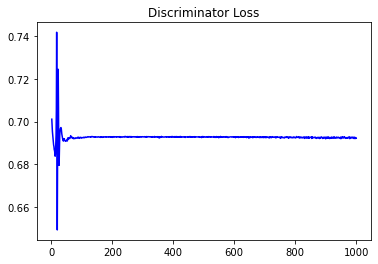

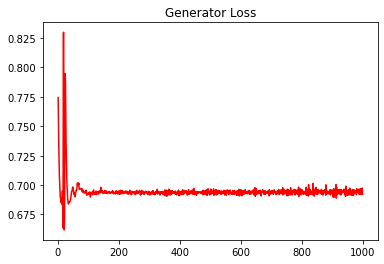

In [12]:
#Training the ABC_GAN 
ABC_train_test2.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [13]:
ABC_GAN1_metrics=ABC_train_test2.test_generator(gen,test_data,prior_model,variance,bias,"1",device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

print("MAE")
print(mean(ABC_GAN1_metrics[1]))

MAE
0.5488019900619984


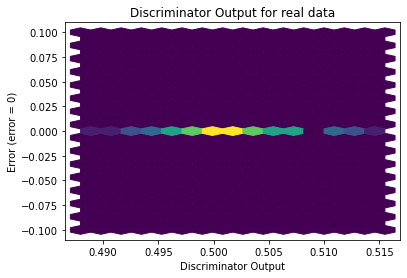

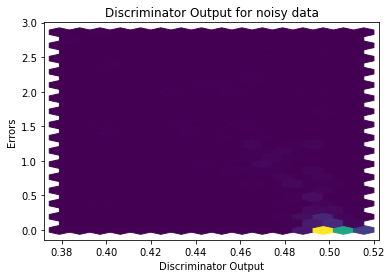

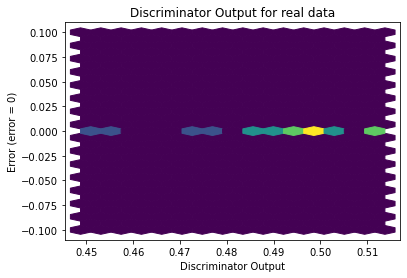

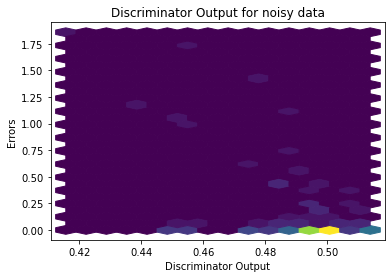

In [14]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# mGAN Model with TabNet Generator

In [15]:
gen2 = network.GeneratorTabnet(n_features+1).to(device)
disc2 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.001, betas=(0.5, 0.999))

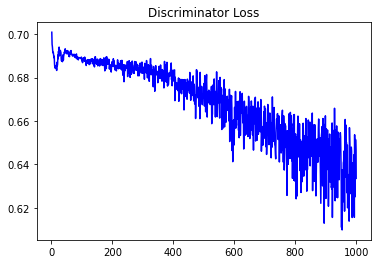

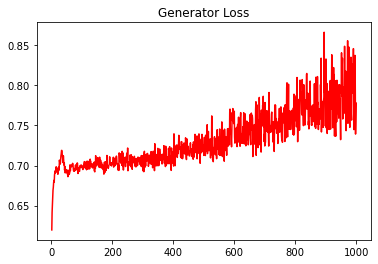

In [16]:
#Training the ABC_GAN 
ABC_train_test2.training_GAN(disc2,gen2,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [17]:
ABC_GAN2_metrics=ABC_train_test2.test_generator(gen2,test_data,prior_model,variance,bias,"1",device)
sb.glue("ABC_GAN_2 Metrics",ABC_GAN2_metrics)

print("MAE")
print(mean(ABC_GAN2_metrics[1]))

MAE
0.6270533552551643


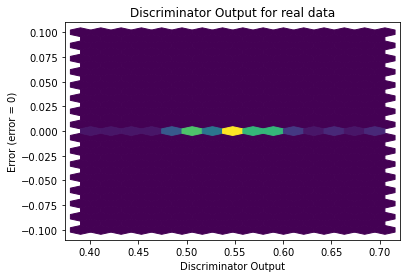

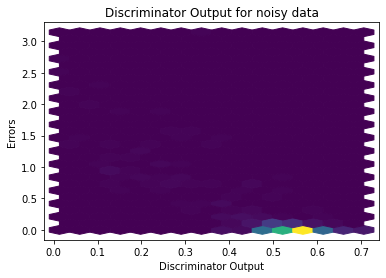

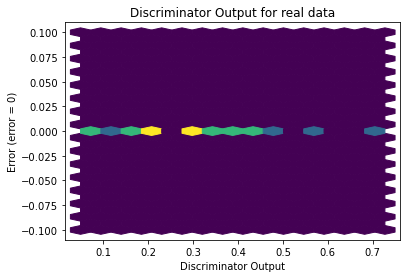

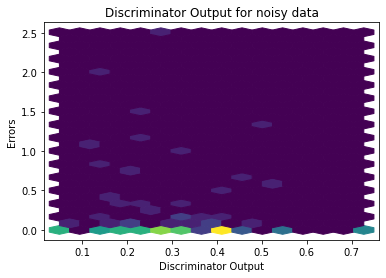

In [18]:
sanityChecks.discProbVsError(train_data,disc2,device)
sanityChecks.discProbVsError(test_data,disc2,device)

# skipGAN Model

In [19]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.001, betas=(0.5, 0.999))


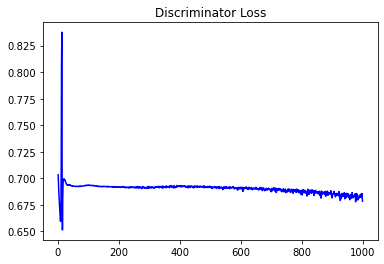

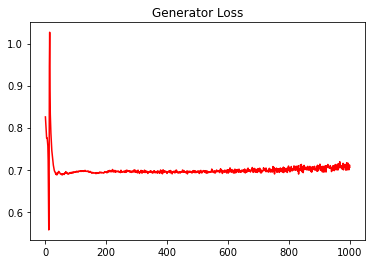

In [20]:
ABC_train_test2.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [21]:
ABC_GAN3_metrics=ABC_train_test2.test_generator(gen3,test_data,prior_model,variance,bias,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MAE")
print(mean(ABC_GAN3_metrics[1]))

MAE
0.5953158089444042


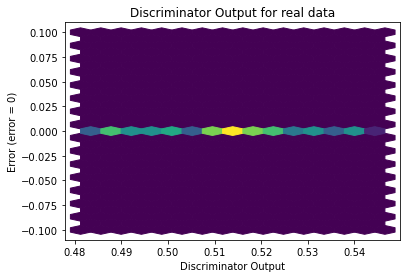

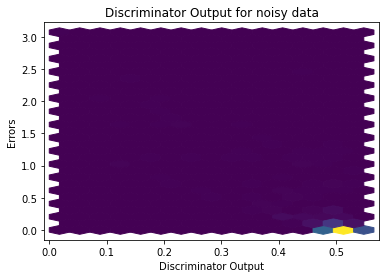

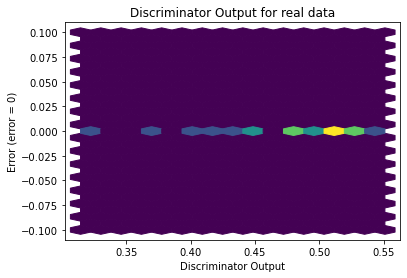

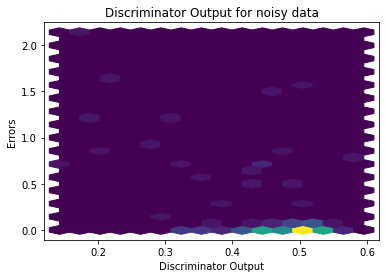

In [22]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

# skipGAN Model with TabNet Generator

In [23]:
#Generator
gen4 = network.GeneratorTabnetskipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc4 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen4.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc4.parameters(), lr=0.001, betas=(0.5, 0.999))


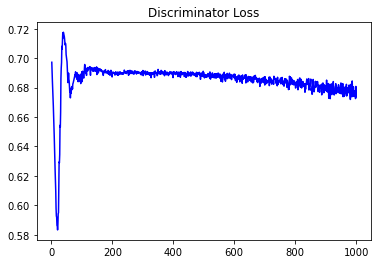

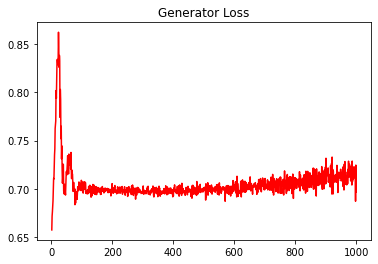

In [24]:
ABC_train_test2.training_GAN_skip_connection(disc4,gen4,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,bias,device)

In [25]:
ABC_GAN4_metrics=ABC_train_test2.test_generator(gen4,test_data,prior_model,variance,bias,"3",device)
sb.glue("ABC_GAN_4 Metrics",ABC_GAN4_metrics)

print("MAE")
print(mean(ABC_GAN4_metrics[1]))

MAE
0.6007386878579855


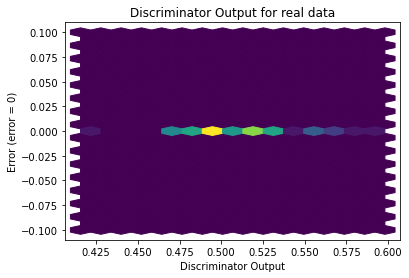

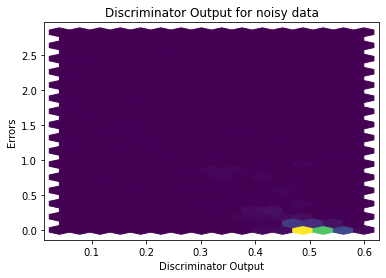

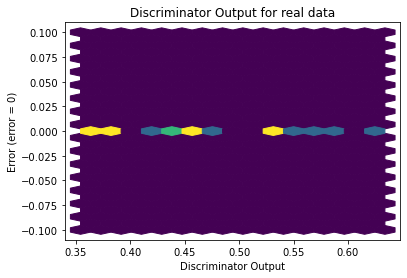

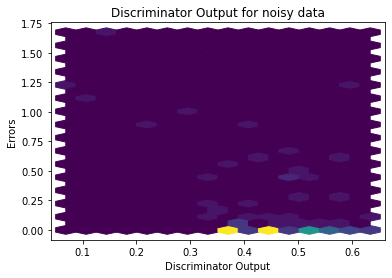

In [26]:
sanityChecks.discProbVsError(train_data,disc4,device)
sanityChecks.discProbVsError(test_data,disc4,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [27]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.0761]], requires_grad=True)


## skipGAN Model Analysis (TabNet Generator) 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [28]:
print("Weight of the node at skip connection")
for name,param in gen4.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.1710]], requires_grad=True)
